# Library importation

In [1]:
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
from collections import Counter
from datetime import datetime
from imutils import paths
import time
from sklearn.neighbors import KNeighborsClassifier
from skimage import exposure, feature
from sklearn.model_selection import train_test_split
import imutils
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.base import clone
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Data importation

In [2]:
DATA_PATH='/Users/samy/Desktop/BINL/Final Project/dataset'

TRAIN_IMAGE_PATH=os.path.join(DATA_PATH, 'train')
TEST_IMAGE_PATH=os.path.join(DATA_PATH, 'test')

In [3]:
def get_image_filenames(image_path, image_type):
    if(os.path.exists(image_path)):
        return glob.glob(os.path.join(image_path, '*.'+image_type))
    return

In [4]:
train = get_image_filenames(TRAIN_IMAGE_PATH, "jpeg")
test = get_image_filenames(TEST_IMAGE_PATH, "jpeg")

train_size = 4000
test_size = 150

random.shuffle(train)
random.shuffle(test)

train = train[:train_size]
test = test[:test_size]

# EDA - Computer vision tools

In [5]:
def FEN_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

In [6]:
print(FEN_from_filename(train[0]))
print(FEN_from_filename(train[1]))
print(FEN_from_filename(train[2]))

8-1Pr5-8-4KP2-6k1-8-8-7b
Bnb2K2-8-6n1-n7-4B2k-5bp1-p7-4r3
7B-4B3-8-1NK5-1Q2k2r-4R3-8-8


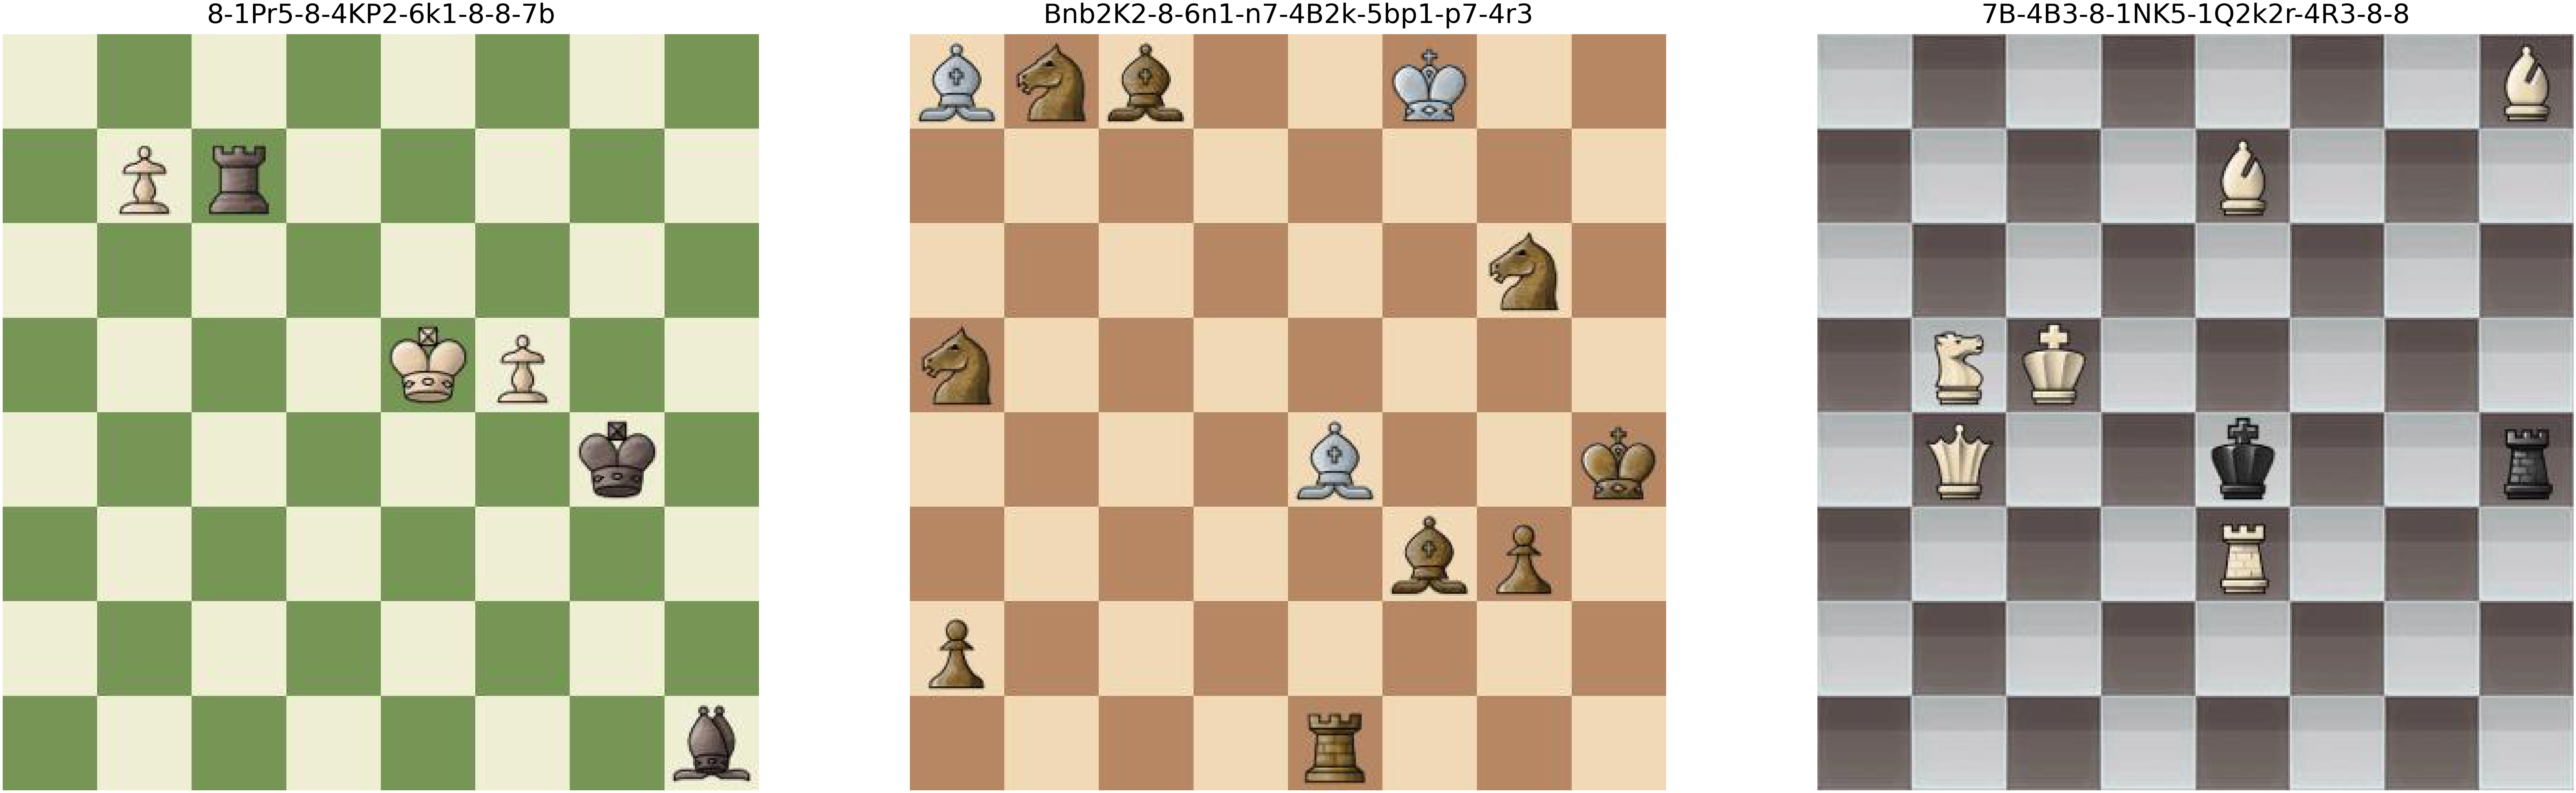

In [7]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(FEN_from_filename(train[i]), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

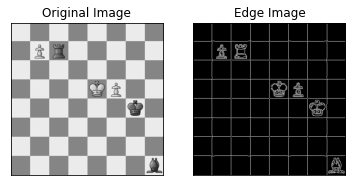

In [9]:
image = image = cv2.imread(train[0],0)
edges = imutils.auto_canny(image)

plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [10]:
# Separation of each square in a list

list_of_squares = []
row_of_squares=np.array_split(edges, 8)

for i in range(8):
    square=np.array_split(row_of_squares[i], 8, axis=1)
    for j in range(8):
        list_of_squares.append(square[j])

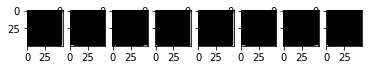

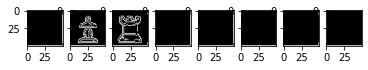

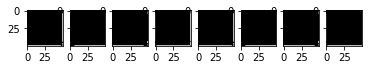

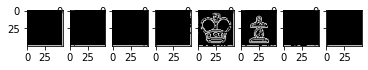

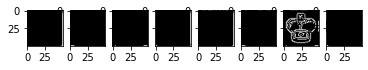

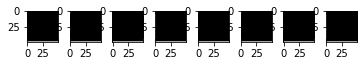

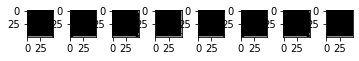

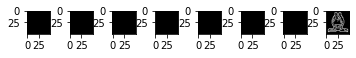

In [11]:
for i in range(8):
    k = i*8
    for j in range(8):
        plt.subplot(i+1,8,j+1)
        plt.imshow(list_of_squares[j+k],cmap='gray')
    plt.show()

# Some functions to prepare data

### Retrieve squares from an image

In [13]:
def get_squares_images(list_of_squares, image):
   
    # Divide the image in 64 squares and fill it into a the list
    
    row_of_squares=np.array_split(image, 8)
    # Divide by row
    for i in range(8):
        square=np.array_split(row_of_squares[i], 8, axis=1)
        # Divide by column
        for j in range(8):
            list_of_squares.append(square[j])
    return list_of_squares

### Label squares thanks to FEN description

In [14]:
def get_label_from_FEN(labels, FEN_description):
    for i in FEN_description:
        # Test whether it's a number which means an empty squar or not
        if i.isdigit():
            k=int(i)
            for j in range(k):
                labels.append('Nothing')
        else:
            labels.append(i)
    return labels

### Keep only non empty squares

In [15]:
def get_non_empty_squares(data, labels):
    new_labels = []
    new_data = data.copy()
    index=[]
    # Scrol the list to filter out empty square
    for (i,label) in enumerate(labels):
        if label!='Nothing':
            new_labels.append(label)
        else:
            index.append(i)       
    index.reverse()
    for i in index:
        new_data.pop(i)
    return new_data, new_labels

### Compute HOG feature

In [16]:
def get_HOG_feature(list_of_squares):
    data = []  
    for square in list_of_squares:
        # Convert it to grayscale and detect edges
        gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
        edged = imutils.auto_canny(gray)
    
        # Find contours in the edged squares, keeping only the largest one which
        # is presumed to be the pawn
        cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c = max(cnts, key=cv2.contourArea)
        
        # Extract the pawn and resize it
        (x, y, w, h) = cv2.boundingRect(c)
        pawn = gray[y:y + h, x:x + w]
        pawn = cv2.resize(pawn, (50, 50))
    
        # Extract Histogram of Oriented Gradients from the pawn
        H = feature.hog(pawn, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

        # Update the data
        data.append(H)
    return data

### Compute HSV

In [17]:
def HSV(square):
    HSV = cv2.cvtColor(square,cv2.COLOR_BGR2HSV)
    return HSV

### Compute Gradient

In [18]:
def gradient(square):
    gray = cv2.cvtColor(square,cv2.COLOR_BGR2GRAY)

    # Convert image gradient in x direction
    sobelx = cv2.Sobel(gray, 0, dx=1, dy=0)
    sobelx = np.uint8(np.absolute(sobelx))

    # Convert image gradient in y direction
    sobely = cv2.Sobel(gray, 0, dx=0, dy=1)
    sobely = np.uint8(np.absolute(sobely))
        
    # Compute the gradient
    gradient = np.sqrt(np.square(sobelx)+np.square(sobely))
    
    return gradient

# Data preparation

## Train set

In [19]:
train_squares=[]
train_labels = []

# Loop over the image paths in the training set
for image_path in train:
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Retrieve FEN description 
    FEN = FEN_from_filename(image_path)
    FEN = FEN.replace("-", "")
    
    # Get the 64 squares from the image
    list_of_squares_from_image=[]
    get_squares_images(list_of_squares_from_image, image)
    train_squares.extend(list_of_squares_from_image)
    
    # Label the image squares
    get_label_from_FEN(train_labels, FEN)

In [20]:
# Filter out empty squares
train_filtered_squares, train_filtered_labels=get_non_empty_squares(train_squares, train_labels)

<AxesSubplot:>

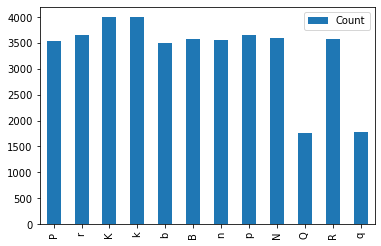

In [21]:
counts_train = Counter(train_filtered_labels)
df_train = pd.DataFrame.from_dict(counts_train,orient='index',columns=['Count'])
df_train.plot(kind='bar')

In [22]:
# Pourcentage of non empty squares
len(train_filtered_labels)/len(train_labels)*100

15.678515625

##### Optionnal

In [ ]:
path_train_squares ='/Users/samy/Desktop/LSMA/Final Project/dataset/train_squares/'

# Clean the folder
files = glob.glob(path_train_squares+'*')
for f in files:
    os.remove(f)

# Save squares into the folder
for i in range(len(train_filtered_squares)):
    # Name by time to have an unique name 
    now = datetime.now()
    name = now.strftime("%H:%M:%S.%f %d-%m-%Y")
    cv2.imwrite(path_train_squares+name+'.png',train_filtered_squares[i])

## Test set

In [23]:
test_labels = []
test_squares = []
    
for image_path in test:
    # Load the image
    image = cv2.imread(image_path)
    
    # Retrieve FEN description 
    FEN = FEN_from_filename(image_path)
    FEN = FEN.replace("-", "")
            
    # Get the 64 squares from the image
    get_squares_images(test_squares, image)
    
    # Label the image squares
    get_label_from_FEN(test_labels, FEN)

In [24]:
# Filter out empty square
test_filtered_squares, test_filtered_labels=get_non_empty_squares(test_squares, test_labels)

<AxesSubplot:>

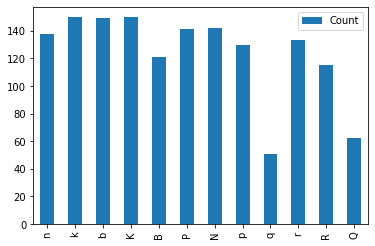

In [25]:
counts_test = Counter(test_filtered_labels)
df_test = pd.DataFrame.from_dict(counts_test,orient='index',columns=['Count'])
df_test.plot(kind='bar')

In [26]:
len(test_filtered_labels)/len(test_labels)*100

15.437500000000002

##### Optionnal

In [ ]:
path_test_squares ='/Users/samy/Desktop/LSMA/Final Project/dataset/test_squares/'

# Clean the folder
files = glob.glob(path_test_squares+'*')
for f in files:
    os.remove(f)
    
# Save squares into the folder
for i in range(len(test_filtered_squares)):
    # name by time to have an unique name 
    now = datetime.now()
    name = now.strftime("%H:%M:%S.%f %d-%m-%Y")
    cv2.imwrite(path_test_squares+name+'.png',test_filtered_squares[i])

###  Computation of HOG feature

### Train data

In [27]:
# Initialize the data matrix and labels
print("[INFO] extracting features...")

# Get starting time
start = time.time()

train_data=get_HOG_feature(train_filtered_squares)

# Get time taken to run
elapsed_time_fl = (time.time() - start)
print(elapsed_time_fl/60)

[INFO] extracting features...
0.9519115010897319


### Test data

In [28]:
# Initialize the data matrix and labels
print("[INFO] extracting features...")

test_data=get_HOG_feature(test_filtered_squares)

[INFO] extracting features...


# Classify the type of pawn

### Encoding labels

In [30]:
# Creating labelEncoder
encoder = preprocessing.LabelEncoder()

# Converting string labels into numbers
labels_encoded=encoder.fit_transform(train_filtered_labels)

## KNN

### Training - KNN

In [31]:
# Train the KNN classifier
print("[INFO] training classifier...")
model_KNN = KNeighborsClassifier(n_neighbors=1)
model_KNN.fit(train_data, labels_encoded)

[INFO] training classifier...


KNeighborsClassifier(n_neighbors=1)

### Evaluation - KNN

In [ ]:
print("[INFO] evaluating...")
# Loop over the test dataset
for (i, image_path) in enumerate(paths.list_images("/Users/samy/Desktop/LSMA/Final Project/dataset/test_squares")):
    # Load the test image, convert it to grayscale and resize it 
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = imutils.auto_canny(gray)
    edged = cv2.resize(edged, (50, 50))

    # Extract Histogram of Oriented Gradients from the test image and predict the pawn
    (H, hogImage) = feature.hog(edged, orientations=9, pixels_per_cell=(4, 4),
        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
    pred = model_KNN.predict(H.reshape(1, -1))[0]
    pred = encoder.inverse_transform([pred])
    pred = ''.join(pred)

    # Visualize the HOG image
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    print("HOG Image #{}".format(i + 1))
    plt.imshow(hogImage)
    plt.show()

    # Draw the prediction on the test image and display it
    cv2.putText(image, pred, (18, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    print("Test Image #{}".format(i + 1))
    plt.imshow(image)
    plt.show()

In [32]:
# Encode test labels
labels_test_encoded=encoder.fit_transform(test_filtered_labels)

# Compute confusion matrix
KNN_prediction = model_KNN.predict(test_data)
cm_KNN = confusion_matrix(labels_test_encoded, KNN_prediction)

In [33]:
pawn = encoder.classes_
categories = np.ndarray.tolist(pawn)

<AxesSubplot:>

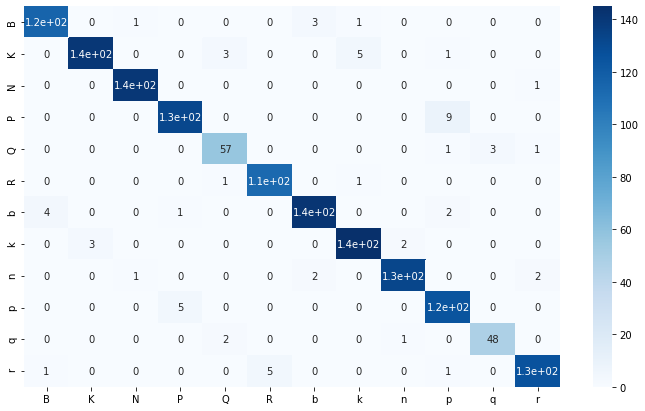

In [34]:
cm_df = pd.DataFrame(cm_KNN,categories,categories)                      
plt.figure(figsize=(12,7))  
sns.heatmap(cm_df, annot=True, cmap='Blues', )

<AxesSubplot:>

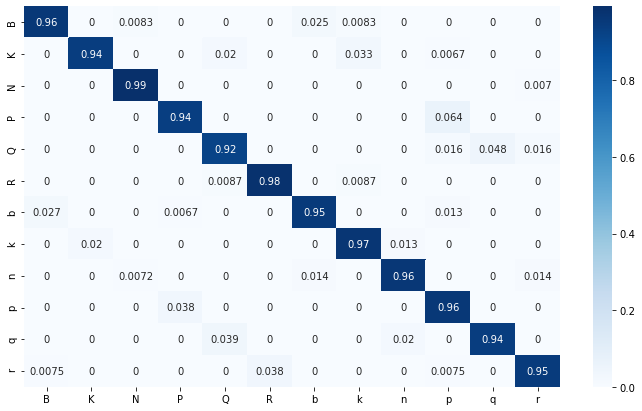

In [35]:
# Normalize confusion matrix
cm_normalize = cm_KNN.astype('float') / cm_KNN.sum(axis=1)[:, np.newaxis]

cm_normalize_df = pd.DataFrame(cm_normalize, categories, categories)                      
plt.figure(figsize=(12,7))
sns.heatmap(cm_normalize_df, annot=True, cmap='Blues', )

In [36]:
print(classification_report(labels_test_encoded, KNN_prediction, target_names=pawn))

              precision    recall  f1-score   support

           B       0.96      0.96      0.96       121
           K       0.98      0.94      0.96       150
           N       0.99      0.99      0.99       142
           P       0.96      0.94      0.95       141
           Q       0.90      0.92      0.91        62
           R       0.96      0.98      0.97       115
           b       0.97      0.95      0.96       149
           k       0.95      0.97      0.96       150
           n       0.98      0.96      0.97       138
           p       0.90      0.96      0.93       130
           q       0.94      0.94      0.94        51
           r       0.97      0.95      0.96       133

    accuracy                           0.96      1482
   macro avg       0.95      0.96      0.95      1482
weighted avg       0.96      0.96      0.96      1482



## SVM

### Training - SVM

In [37]:
# Train the KNN classifier
print("[INFO] training classifier...")

# Create a svm Classifier
model_SVM = LinearSVC() # Linear Kernel 
model_SVM.fit(train_data, labels_encoded)

[INFO] training classifier...


LinearSVC()

### Evaluation - SVM

In [38]:
# Compute confusion matrix
SVM_prediction = model_SVM.predict(test_data)
cm_SVM = confusion_matrix(labels_test_encoded, SVM_prediction)

<AxesSubplot:>

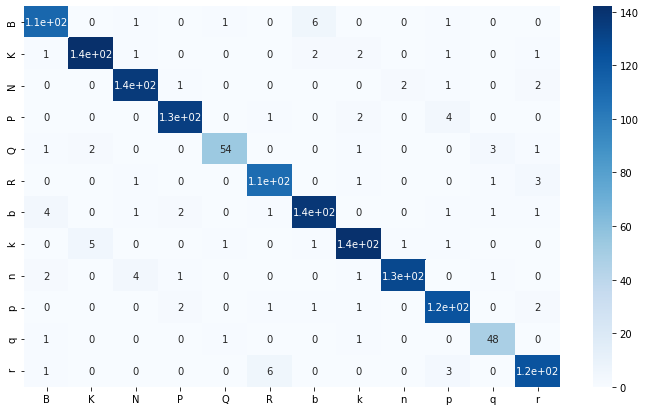

In [39]:
cm_df = pd.DataFrame(cm_SVM,categories,categories)                      
plt.figure(figsize=(12,7))  
sns.heatmap(cm_df, annot=True, cmap='Blues')

<AxesSubplot:>

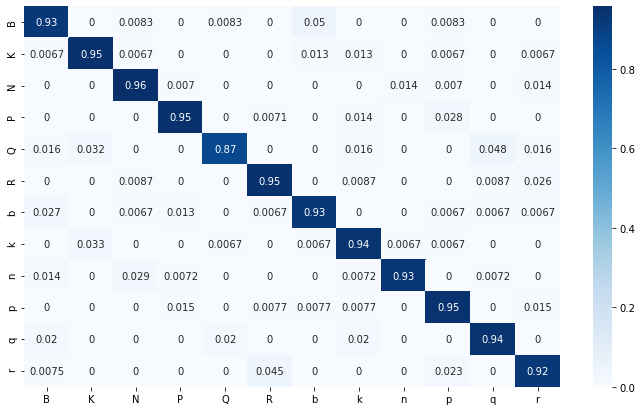

In [40]:
# Normalize confusion matrix
cm_normalize = cm_SVM.astype('float') / cm_SVM.sum(axis=1)[:, np.newaxis]

cm_normalize_df = pd.DataFrame(cm_normalize, categories, categories)                      
plt.figure(figsize=(12,7))
sns.heatmap(cm_normalize_df, annot=True, cmap='Blues', )

In [41]:
print(classification_report(labels_test_encoded, SVM_prediction, target_names=pawn))

              precision    recall  f1-score   support

           B       0.92      0.93      0.92       121
           K       0.95      0.95      0.95       150
           N       0.94      0.96      0.95       142
           P       0.96      0.95      0.95       141
           Q       0.95      0.87      0.91        62
           R       0.92      0.95      0.94       115
           b       0.93      0.93      0.93       149
           k       0.94      0.94      0.94       150
           n       0.98      0.93      0.96       138
           p       0.91      0.95      0.93       130
           q       0.89      0.94      0.91        51
           r       0.92      0.92      0.92       133

    accuracy                           0.94      1482
   macro avg       0.93      0.93      0.93      1482
weighted avg       0.94      0.94      0.94      1482



# Detection of non-empty squares

In [42]:
dframe = pd.DataFrame(train_labels, columns =['label'])  
dframe['square'] = train_squares
dframe.head()

,label,square
0,Nothing,"[[[212, 238, 238], [212, 238, 238], [212, 238,..."
1,Nothing,"[[[98, 143, 127], [93, 150, 125], [85, 147, 11..."
2,Nothing,"[[[197, 242, 226], [204, 244, 233], [208, 239,..."
3,Nothing,"[[[95, 143, 125], [93, 147, 124], [90, 147, 12..."
4,Nothing,"[[[203, 243, 231], [208, 240, 235], [212, 237,..."


### Compute features

In [43]:
dframe['HSV'] = dframe['square'].apply(HSV)
dframe['gradient'] = dframe['square'].apply(gradient)

In [44]:
dframe['mean_H'] = dframe['HSV'].apply(lambda x: x[...,0].mean())
dframe['std_H'] = dframe['HSV'].apply(lambda x: x[...,0].std())
dframe['mean_S'] = dframe['HSV'].apply(lambda x: x[...,1].mean())
dframe['std_S'] = dframe['HSV'].apply(lambda x: x[...,1].std())
dframe['mean_V'] = dframe['HSV'].apply(lambda x: x[...,2].mean())
dframe['std_V'] = dframe['HSV'].apply(lambda x: x[...,2].std())
dframe['mean_gradient'] = dframe['gradient'].apply(lambda x: x.mean())

In [45]:
dframe['empty'] = dframe['label'].apply(lambda x: 1 if x=='Nothing' else 0)

In [46]:
dframe = dframe.drop(['square','gradient','HSV','label'], axis=1)

In [47]:
dframe.describe()

,mean_H,std_H,mean_S,std_S,mean_V,std_V,mean_gradient,empty
count,256000.000000,256000.000000,256000.000000,256000.000000,256000.000000,256000.000000,256000.000000,256000.000000
mean,41.678384,14.755437,64.698552,11.877913,183.981791,15.592394,3.623539,0.843215
std,38.632058,21.836338,55.526023,15.414257,47.925336,20.709510,2.403184,0.363599
min,0.000000,0.000000,0.000000,0.000000,44.886800,0.000000,0.000000,0.000000
25%,14.994800,0.944720,12.036400,3.690030,153.982400,3.789905,0.933105,1.000000
50%,23.166400,1.856458,55.310600,6.365953,190.095800,6.033071,4.062500,1.000000
75%,60.519000,25.910118,106.948400,12.107824,226.412000,15.098373,5.921875,1.000000
max,174.814800,84.891772,225.438000,105.153887,255.000000,115.772552,7.574219,1.000000


<AxesSubplot:>

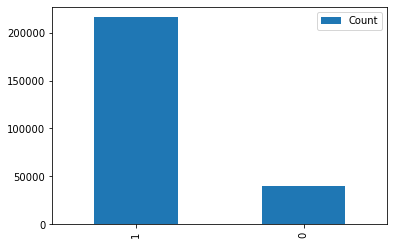

In [48]:
counts_test = Counter(dframe['empty'])
df_test = pd.DataFrame.from_dict(counts_test,orient='index',columns=['Count'])
df_test.plot(kind='bar')

### Define Train and Test set

In [49]:
X, y = dframe.iloc[:, 0:7].values, dframe.iloc[:, 7].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [50]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [51]:
SVM_detection = LinearSVC() # Linear Kernel 
SVM_detection.fit(X_train_std, y_train)
print('Training accuracy:', SVM_detection.score(X_train_std, y_train))
print('Test accuracy:', SVM_detection.score(X_test_std, y_test))

Training accuracy: 0.995
Test accuracy: 0.9949088541666666


In [52]:
# Compute confusion matrix
prediction_SVM = SVM_detection.predict(X_test_std)
cm_svm = confusion_matrix(y_test, prediction_SVM)

<AxesSubplot:>

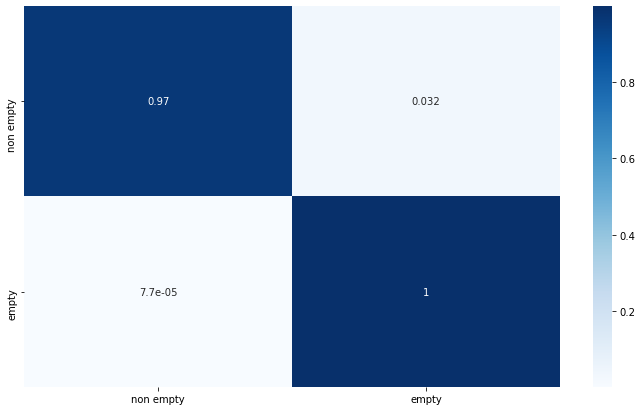

In [54]:
# Normalize confusion matrix
cm_normalize = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]

cm_normalize_df = pd.DataFrame(cm_normalize, ['non empty','empty'], ['non empty','empty'])                      
plt.figure(figsize=(12,7))
sns.heatmap(cm_normalize_df, annot=True, cmap='Blues', )

In [55]:
class SBS():
    
    def __init__(self, estimator, k_features, scoring=accuracy_score,test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                            random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
            self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

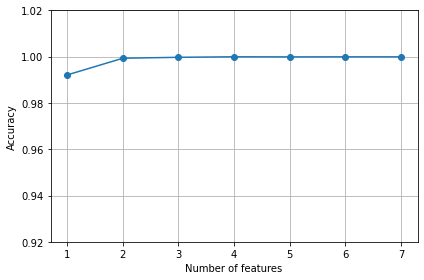

In [56]:
knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.92, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()

In [57]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6),
 (0, 1, 2, 3, 5, 6),
 (0, 2, 3, 5, 6),
 (2, 3, 5, 6),
 (3, 5, 6),
 (3, 5),
 (5,)]

In [58]:
k2 = list(sbs.subsets_[5])
print(dframe.columns[1:][k2])

Index(['mean_V', 'mean_gradient'], dtype='object')


In [59]:
knn.fit(X_train_std[:, k2], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k2], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k2], y_test))

Training accuracy: 0.9994475446428571
Test accuracy: 0.9994401041666666


In [60]:
# Compute confusion matrix
prediction_knn = knn.predict(X_test_std[:, k2])
cm_knn = confusion_matrix(y_test, prediction_knn)

<AxesSubplot:>

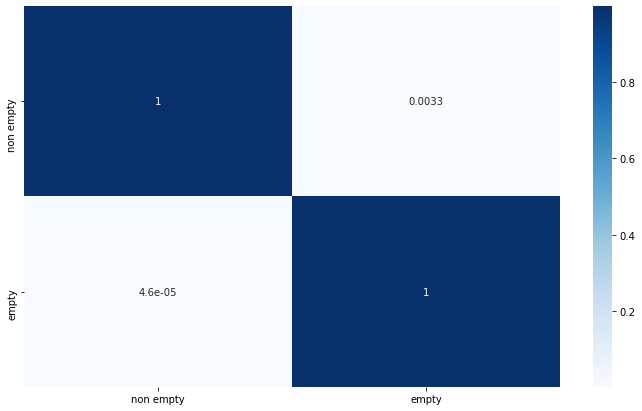

In [61]:
# Normalize confusion matrix
cm_normalize = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]

cm_normalize_df = pd.DataFrame(cm_normalize, ['non empty','empty'], ['non empty','empty'])                      
plt.figure(figsize=(12,7))
sns.heatmap(cm_normalize_df, annot=True, cmap='Blues', )

# Generate FEN from an image

### Some functions to apply the classifier and return the FEN descriptor

In [92]:
def FEN_from_classifier(path):
    image=cv2.imread(path)
    FEN_description = []
    list_of_squares = []
    list_of_squares = get_squares_images(list_of_squares,image)
    column = 0
    k=0
    
    for i in range(len(list_of_squares)):
        column = column+1
        gray = cv2.cvtColor(list_of_squares[i], cv2.COLOR_BGR2GRAY)
        edged = imutils.auto_canny(gray)
        
        # Compute features for detecting non-empty square
        grad = gradient(list_of_squares[i])
        hsv = HSV(list_of_squares[i])
        mean_H = hsv[...,0].mean()
        std_H = hsv[...,0].std()
        mean_S = hsv[...,1].mean()
        std_S = hsv[...,1].std()
        mean_V = hsv[...,2].mean()
        std_V = hsv[...,2].std()
        mean_gradient = grad.mean()
        features = np.array([mean_H, std_H, mean_S, std_S, mean_V, std_V, mean_gradient]) 
        
        # Standardization
        features = stdsc.transform(features.reshape(1, -1))

        # Predict whether it's empty or not
        empty = SVM_detection.predict(features)
    
        # Check whether the square is empty or not
        if empty==1:
            FEN_description.append('1')
        else:
            # Compute HOG
            cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            c = max(cnts, key=cv2.contourArea)
            (x, y, w, h) = cv2.boundingRect(c)
            pawn = gray[y:y + h, x:x + w]
            pawn = cv2.resize(pawn, (50, 50))
            data = [feature.hog(pawn, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")]
        
            # Classify the pawn
            pawn = model_KNN.predict(data)
            pawn = encoder.inverse_transform(pawn)
            FEN_description.append(pawn[0])
    
        # Add "-" to notify we change the row
        if column==8:
            FEN_description.append('-')
            column=0
    FEN_description=suitable_form(FEN_description)
    return FEN_description

In [93]:
def suitable_form(FEN_description):
    A=''
    k=0
    for i in FEN_description:
        if i.isdigit():
            k=k+1
        elif i=='-':
            A=A+str(k)+'-'
            k=0
        else:
            A=A+str(k)+i
            k=0
    A=A.replace('0','')
    A=A[:-1]
    return A

### Evaluate

In [94]:
accuracy=0

for path in test:
    FEN_description=FEN_from_classifier(path)
    if FEN_description==FEN_from_filename(path):
        accuracy=accuracy+1

In [95]:
100*accuracy/len(test)

63.333333333333336